# Analyse Textuelle

## Introduction

### Explorer les textes à l'aide du modèle d'espace vectoriel

Cours basé sur -> [Humanities Data Analysis: Case Studies with Python](https://press.princeton.edu/books/ebook/9780691200330/humanities-data-analysis)


Ce notebook explore la possibilité d'appliquer un raisonnement spatial aux données textuelles, en se demandant si l'on peut considérer les textes comme de simples points dans un espace, ayant des coordonnées exactes permettant de calculer la distance qui les sépare. L'idée est d'utiliser un modèle de vecteurs pour représenter les caractéristiques individuelles des textes, les transformant ainsi en nombres concrets nécessaires au traitement ultérieur. La métaphore du texte en tant que carte aide à comprendre pourquoi la géométrie, l'étude mathématique de l'espace, est essentielle à l'analyse textuelle informatique. 

La première partie de ce notebook se concentre sur les étapes de prétraitement des données et la conversion d'un corpus en une représentation sac de mots. La deuxième partie présente une étude de cas sur les textes romanesques, utilisant le modèle de vecteurs et explorant les différences entre les sous-genres.

```
Exemple de représentation dans un espace vectoriel avec quatre documents (lignes) et un vocabulaire de quatre mots (colonnes). Pour chaque document, le tableau répertorie la fréquence de chaque élément du vocabulaire.

|          | _roi_ | _ange_ | _sang_ | _perdu_ |
|----------|-------|--------|--------|---------|
| $text_1$ |     1 |      2 |     16 |      21 |
| $text_2$ |     2 |      2 |     18 |      19 |
| $text_3$ |    35 |     41 |      0 |       2 |
| $text_4$ |    39 |     55 |      1 |       0 |
```

Dans ce tableau, chaque document $text_i$ est représenté sous forme de vecteur, qui est essentiellement une liste de nombres - les fréquences des mots dans notre cas présent. Un <span class="index">espace vectoriel</span> n'est rien de plus qu'une collection de vecteurs numériques, pouvant par exemple être additionnés et multipliés par un nombre. Les documents représentés de cette manière peuvent être comparés en termes de leurs *coordonnées* (ou *composantes*). Par exemple, en comparant les quatre documents sur la base de la deuxième coordonnée, nous observons que les deux premiers documents ($text_1$ et $text_2$) ont des comptes similaires, ce qui pourrait indiquer une certaine similarité entre ces deux documents. Pour obtenir une image plus précise et complète de la similarité des documents, nous aimerions pouvoir les comparer de manière plus holistique, en utilisant *toutes* leurs composantes. Dans notre exemple, chaque document représente un point dans un espace vectoriel à quatre dimensions. Nous pourrions hypothétiser que des documents similaires utilisent des mots similaires et résident donc à proximité les uns des autres dans cet espace. Pour illustrer cela, nous montrons comment visualiser les documents dans l'espace en utilisant les première et troisième composantes.```

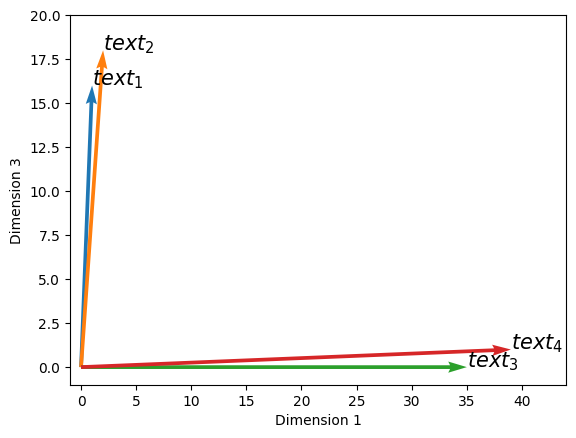

In [1]:
import numpy as np
import matplotlib.pyplot as plt

document_term_matrix = np.array([[1, 16], [2, 18], [35, 0], [39, 1]])
labels = '$text_1$', '$text_2$', '$text_3$', '$text_4$'
fig, ax = plt.subplots()
plt.quiver([0, 0, 0, 0], [0, 0, 0, 0],
           document_term_matrix[:, 0], document_term_matrix[:, 1],
           color=["C0", "C1", "C2", "C3"], angles='xy', scale_units='xy', scale=1)
for i, label in enumerate(labels):
    plt.annotate(label, xy=document_term_matrix[i], fontsize=15)
plt.ylim(-1, 20); plt.xlim(-1, 44)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 3");

Démonstration de quatre documents (représentés sous forme de vecteurs) résidant dans un espace bidimensionnel.

Ayant une compréhension théorique de base du modèle d'espace vectoriel, passons à la partie pratique de la mise en œuvre d'une procédure pour construire une <span class="index">matrice terme-document</span> à partir de texte brut. En essence, cela implique trois étapes: Déterminer le vocabulaire de ducorpus, en filtrant éventuellement les mots outils et la pionctuation. La deuxième étape consiste à compter combien de fois chaque élément du vocabulaire apparaît dans chaque document individuel. La troisième et dernière étape prend les sacs de mots de la deuxième étape et construit une matrice terme-document.

![steps bow](./data/bow.png)

### Prétraitement du texte

Une façon courante de représenter des documents textuels est d'utiliser des chaînes de caractères (associées au type `str` de Python). Considérons le bloc de code suivant, qui représente les dix mini-documents de la figure ci-dessus sous forme d'une liste de chaînes de caractères.

In [2]:
corpus = ["Cette histoire n’est pas fantastique, elle n’est que romanesque.",
          "L’étrange voyage ! Il avait si bien commencé cependant ! Pour ma part, je n’en fis jamais qui s’annonçât sous de plus heureux auspices.",
          "Le vieux baron des Ravots avait été pendant quarante ans le roi des chasseurs de sa province.",
          "La petite ville de Verrières peut passer pour l’une des plus jolies de la Franche-Comté.",
          "Sédentaire par devoir, tu crois, mon cher François, qu’emporté par le fier et capricieux dada de l’indépendance, je n’ai pas connu de plus ardent plaisir en ce monde que celui de traverser mers et montagnes, lacs et vallées.",
          "Que votre nom, vous dont le portrait est le plus bel ornement de cet ouvrage, soit ici comme une branche de buis bénit, prise on ne sait à quel arbre, mais certainement sanctifiée par la religion et renouvelée, toujours verte, par des mains pieuses, pour protéger la maison.",
          '– Et pourquoi cesserais-je d’être de mon village ? Il n’y faut pas compter. Te voilà bien fière, mon pauvre Minet-Chéri, parce que tu habites Paris depuis ton mariage.']

In [3]:
corpus[0].split()

['Cette',
 'histoire',
 'n’est',
 'pas',
 'fantastique,',
 'elle',
 'n’est',
 'que',
 'romanesque.']

Afin de construire une représentation *sac de mots* de chaque "texte" dans ce corpus, nous devons d'abord traiter les chaînes de caractères en mots distincts. Ce processus est appelé *tokenization* ou *segmentation de mots*. Un tokenizer naïf pourrait diviser les documents le long des espaces (contigus). En Python, un tel tokenizer peut être implémenté de manière simple en utilisant la méthode de chaîne `split()`. Comme le montre le bloc de code suivant, cette méthode utilise une stratégie de tokenization dans laquelle les tokens sont séparés par une ou plusieurs occurrences d'espaces (par exemple, des espaces, des tabulations, des sauts de ligne) :

In [4]:
document = corpus[6]
print(document.split())

['–', 'Et', 'pourquoi', 'cesserais-je', 'd’être', 'de', 'mon', 'village', '?', 'Il', 'n’y', 'faut', 'pas', 'compter.', 'Te', 'voilà', 'bien', 'fière,', 'mon', 'pauvre', 'Minet-Chéri,', 'parce', 'que', 'tu', 'habites', 'Paris', 'depuis', 'ton', 'mariage.']


Preprocessing: Choix qui peuvent dépendre de nos questions de recherche - minuscules, ponctuation, mots-outils 

+ Lemmatisation - entrée de dictionnaire

La meilleure recommandation ici est de suivre des stratégies établies et de documenter de manière exhaustive les étapes de prétraitement effectuées. La distribution du code utilisé dans le prétraitement est une excellente idée. De nombreuses applications utilisent des tokenizers prêts à l'emploi pour prétraiter les textes. Dans l'exemple ci-dessous, nous appliquons un tokenizer optimisé pour le français fourni par le *Natural Language ToolKit* (NLTK), et nous segmentons chaque document dans le `corpus` en une liste de jetons (tokens) de mots.


In [5]:
!pip install nltk
>>> import nltk
>>> nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/crazyjeannot/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
import nltk
import nltk.tokenize

# download the most recent punkt package
nltk.download('punkt', quiet=True)

document = corpus[6]
tokens = nltk.tokenize.word_tokenize(document, language='french')

In [7]:
tokens

['–',
 'Et',
 'pourquoi',
 'cesserais-je',
 'd',
 '’',
 'être',
 'de',
 'mon',
 'village',
 '?',
 'Il',
 'n',
 '’',
 'y',
 'faut',
 'pas',
 'compter',
 '.',
 'Te',
 'voilà',
 'bien',
 'fière',
 ',',
 'mon',
 'pauvre',
 'Minet-Chéri',
 ',',
 'parce',
 'que',
 'tu',
 'habites',
 'Paris',
 'depuis',
 'ton',
 'mariage',
 '.']

On peut observer que ce tokenizer divise correctement la ponctuation finale de la phrase, telle que les points, mais conserve les formes contractées, comme *Minet-Chéri*. 

Compte tenu de la segmentation actuelle des mots, il est possible de supprimer les marques de ponctuation isolées (ou répétées) en filtrant les jetons qui ne sont pas de la ponctuation. À cette fin, nous mettons en œuvre une simple fonction utilitaire appelée `is_punct()`, qui vérifie si une chaîne d'entrée donnée est soit un seul marqueur de ponctuation, soit une séquence de ceux-ci :


In [8]:
import re

PUNCT_RE = re.compile(r'[^\w\s]+$')

def is_punct(string):  
    """Vérifiez si STRING est un marqueur de ponctuation ou une séquence de
       marqueurs de ponctuation.

    Arguments:
        string (str): une chaîne à vérifier pour les marqueurs de ponctuation.

    Renvoie:
        bool: True si la chaîne est un (une séquence de) marqueur(s) de ponctuation,
            False sinon.


    Examples:
        >>> is_punct("!")
        True
        >>> is_punct("Bonjour!")
        False
        >>> is_punct("¿Te gusta el verano?")
        False
        >>> is_punct("...")
        True
        >>> is_punct("«»...")
        True

    """
    return PUNCT_RE.match(string) is not None

In [9]:
is_punct("!")

True

La fonction utilise l'**expression régulière** `[^\w\s]+$`. Pour ceux qui ont une mémoire un peu rouillée des expressions régulières, permettez-nous d'expliquer brièvement ses composants. `\w` correspond aux caractères alphanumériques Unicode (y compris les chiffres), et `\s` correspond aux caractères d'espacement Unicode. En utilisant la notation d'ensemble `[]` et le signe de négation `^`, c'est-à-dire `[^\w\s]`, l'expression régulière correspond à tout caractère qui n'est *pas* correspondant à `\w` ou `\s`, c'est-à-dire n'est pas un caractère alphanumérique ou d'espacement, et donc un caractère de ponctuation. Le `+` indique que l'expression doit correspondre à un ou plusieurs caractères de ponctuation, et le `$` correspond à la fin de la chaîne, ce qui garantit qu'une chaîne est uniquement correspondante si elle est constituée uniquement de caractères de ponctuation.

En utilisant la fonction **`is_punct()`**, filtrer tous les jetons qui ne sont pas de la ponctuation peut être accompli en utilisant une boucle `for` ou une **compréhension de liste**. Le bloc de code suivant démontre l'utilisation des deux mécanismes de bouclage, qui sont essentiellement équivalents :


In [10]:
corpus[6] = corpus[6].replace('\xa0', ' ')

In [11]:
corpus[6]

'– Et pourquoi cesserais-je d’être de mon village ? Il n’y faut pas compter. Te voilà bien fière, mon pauvre Minet-Chéri, parce que tu habites Paris depuis ton mariage.'

In [12]:
tokens = corpus

In [13]:
tokenized = []
for token in tokens:
    if not is_punct(token):
        tokenized.append(token)
print(tokenized)

['Cette histoire n’est pas fantastique, elle n’est que romanesque.', 'L’étrange voyage ! Il avait si bien commencé cependant ! Pour ma part, je n’en fis jamais qui s’annonçât sous de plus heureux auspices.', 'Le vieux baron des Ravots avait été pendant quarante ans le roi des chasseurs de sa province.', 'La petite ville de Verrières peut passer pour l’une des plus jolies de la Franche-Comté.', 'Sédentaire par devoir, tu crois, mon cher François, qu’emporté par le fier et capricieux dada de l’indépendance, je n’ai pas connu de plus ardent plaisir en ce monde que celui de traverser mers et montagnes, lacs et vallées.', 'Que votre nom, vous dont le portrait est le plus bel ornement de cet ouvrage, soit ici comme une branche de buis bénit, prise on ne sait à quel arbre, mais certainement sanctifiée par la religion et renouvelée, toujours verte, par des mains pieuses, pour protéger la maison.', '– Et pourquoi cesserais-je d’être de mon village ? Il n’y faut pas compter. Te voilà bien fière,

In [14]:
liste_resultat = [token for token in tokens if not is_punct(token)]

In [15]:
tokens = nltk.tokenize.word_tokenize(corpus[6], language='french')

# Loop with a standard for-loop
tokenized = []
for token in tokens:
    if not is_punct(token):
        tokenized.append(token)
print(tokenized)

# Loop with a list comprehension
tokenized = [token for token in tokens if not is_punct(token)]
print(tokenized)

['Et', 'pourquoi', 'cesserais-je', 'd', 'être', 'de', 'mon', 'village', 'Il', 'n', 'y', 'faut', 'pas', 'compter', 'Te', 'voilà', 'bien', 'fière', 'mon', 'pauvre', 'Minet-Chéri', 'parce', 'que', 'tu', 'habites', 'Paris', 'depuis', 'ton', 'mariage']
['Et', 'pourquoi', 'cesserais-je', 'd', 'être', 'de', 'mon', 'village', 'Il', 'n', 'y', 'faut', 'pas', 'compter', 'Te', 'voilà', 'bien', 'fière', 'mon', 'pauvre', 'Minet-Chéri', 'parce', 'que', 'tu', 'habites', 'Paris', 'depuis', 'ton', 'mariage']


Après la tokenisation et la suppression de la ponctuation, il nous reste une séquence de chaînes alphanumériques ("mots" ou "jetons de mots"). Idéalement, nous envelopperions ces étapes de prétraitement dans une fonction unique, telle que preprocess_text(), qui renvoie une liste de jetons de mots et supprime tous les marqueurs de ponctuation isolés. Considérez l'implémentation suivante :

In [16]:
def preprocess_text(text, language, lowercase=True):
    """Prétraiter un texte.

    Effectuer une procédure de prétraitement de texte, qui transforme une chaîne
    en une liste de jetons de mots sans marqueurs de ponctuation.

    Arguments:
        text (str): une chaîne représentant un texte.
        language (str): une chaîne spécifiant la langue du texte.
        lowercase (bool, facultatif): Définir sur True pour mettre en minuscules tous
            les jetons de mots. Par défaut, True.

    Renvoie:
        list: une liste de jetons de mots extraits du texte, excluant la ponctuation.

    Exemples:
        >>> preprocess_text("Ah! Monsieur, c'est donc vous?", 'french')
        ["ah", "monsieur", "c'est", "donc", "vous"]


    """
    if lowercase:
        text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text, language=language)
    tokens = [token for token in tokens if not is_punct(token)]
    return tokens

Le paramètre `lowercase` peut être utilisé pour transformer tous les jetons de mots en leur forme en minuscules. Pour tester cette nouvelle fonction, nous l'appliquons à certains des documents fictifs dans `corpus` :

In [17]:
for document in corpus[2:9]:
    print('Original:', document)
    print('Tokenized:', preprocess_text(document, 'french'))

Original: Le vieux baron des Ravots avait été pendant quarante ans le roi des chasseurs de sa province.
Tokenized: ['le', 'vieux', 'baron', 'des', 'ravots', 'avait', 'été', 'pendant', 'quarante', 'ans', 'le', 'roi', 'des', 'chasseurs', 'de', 'sa', 'province']
Original: La petite ville de Verrières peut passer pour l’une des plus jolies de la Franche-Comté.
Tokenized: ['la', 'petite', 'ville', 'de', 'verrières', 'peut', 'passer', 'pour', 'l', 'une', 'des', 'plus', 'jolies', 'de', 'la', 'franche-comté']
Original: Sédentaire par devoir, tu crois, mon cher François, qu’emporté par le fier et capricieux dada de l’indépendance, je n’ai pas connu de plus ardent plaisir en ce monde que celui de traverser mers et montagnes, lacs et vallées.
Tokenized: ['sédentaire', 'par', 'devoir', 'tu', 'crois', 'mon', 'cher', 'françois', 'qu', 'emporté', 'par', 'le', 'fier', 'et', 'capricieux', 'dada', 'de', 'l', 'indépendance', 'je', 'n', 'ai', 'pas', 'connu', 'de', 'plus', 'ardent', 'plaisir', 'en', 'ce', 

### Créer une matrice terme-document:

In [18]:
import collections

vocabulary = collections.Counter()

for document in corpus:
    vocabulary.update(preprocess_text(document, 'french'))

`Counter` implémente plusieurs méthodes spécialisées pour des comptages pratiques et rapides. Par exemple, la méthode <span class="index">`Counter.most_common`</span> renvoie les *n* éléments les plus fréquents :

In [19]:
print(vocabulary.most_common(n=5))

[('de', 10), ('n', 5), ('le', 5), ('et', 5), ('que', 4)]


In [20]:
vocabulary

Counter({'de': 10,
         'n': 5,
         'le': 5,
         'et': 5,
         'que': 4,
         'plus': 4,
         'des': 4,
         'la': 4,
         'par': 4,
         'est': 3,
         'pas': 3,
         'l': 3,
         'pour': 3,
         'mon': 3,
         'il': 2,
         'avait': 2,
         'bien': 2,
         'je': 2,
         'en': 2,
         'une': 2,
         'tu': 2,
         'cette': 1,
         'histoire': 1,
         'fantastique': 1,
         'elle': 1,
         'romanesque': 1,
         'étrange': 1,
         'voyage': 1,
         'si': 1,
         'commencé': 1,
         'cependant': 1,
         'ma': 1,
         'part': 1,
         'fis': 1,
         'jamais': 1,
         'qui': 1,
         's': 1,
         'annonçât': 1,
         'sous': 1,
         'heureux': 1,
         'auspices': 1,
         'vieux': 1,
         'baron': 1,
         'ravots': 1,
         'été': 1,
         'pendant': 1,
         'quarante': 1,
         'ans': 1,
         'roi': 1,
   

Comme on peut le constater, les mots les plus fréquents dans le vocabulaire sont des mots fonctionnels (ou "<span class="index">mots vides</span>" comme on les appelle couramment), tels que *le* (déterminant), *et* (conjonction), et *de* (préposition). Les mots situés dans les rangs inférieurs de la liste de fréquence sont généralement des <span class="index">mots de contenu</span> qui ont un sens plus spécifique que les mots fonctionnels. En utilisant l'objet `Counter` construit ci-dessus, il est facile de composer un vocabulaire qui ignore ces hapax :

In [21]:
print('Original vocabulary size:', len(vocabulary))
pruned_vocabulary = {token for token, count in vocabulary.items() if count > 1}
print(pruned_vocabulary)
print('Pruned vocabulary size:', len(pruned_vocabulary))

Original vocabulary size: 134
{'pas', 'mon', 'bien', 'il', 'en', 'pour', 'des', 'avait', 'je', 'une', 'est', 'le', 'et', 'que', 'tu', 'n', 'de', 'la', 'plus', 'l', 'par'}
Pruned vocabulary size: 21


Pour rafraîchir votre mémoire, un ensemble Python <span class="index">`set`</span> est une structure de données bien adaptée pour représenter un vocabulaire. Un ensemble Python, à l'instar de son homologue en mathématiques, est une séquence non ordonnée d'éléments distincts. Comme un ensemble enregistre uniquement des éléments distincts, nous sommes assurés que tous les mots qui y apparaissent sont uniques. De manière similaire, nous pourrions construire un vocabulaire qui exclut les *n* jetons les plus fréquents :

In [22]:
n = 30
print('Original vocabulary size:', len(vocabulary))
pruned_vocabulary = {token for token, _ in vocabulary.most_common()[n:]}
print('Pruned vocabulary size:', len(pruned_vocabulary))

Original vocabulary size: 134
Pruned vocabulary size: 104


Notez comment la taille du vocabulaire élagué peut effectivement être réduite de manière agressive en utilisant de simples seuils de fréquence. En abstrayant ces deux routines concrètes, nous pouvons maintenant implémenter une fonction <span class="index">`extract_vocabulary()`</span>, qui extrait un vocabulaire à partir d'un corpus tokenisé en fonction d'un comptage de fréquence minimum et maximum :

In [23]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
    """Extraire un vocabulaire à partir d'un corpus tokenisé.

    Arguments:
        tokenized_corpus (list): un corpus tokenisé, représenté par une liste
            de listes de chaînes.
        min_count (int, facultatif): le nombre minimum d'occurrences d'un élément
            du vocabulaire dans le corpus.
        max_count (int, facultatif): le nombre maximum d'occurrences d'un élément
            du vocabulaire dans le corpus. Par défaut, infini.

    Renvoie:
        list: Une liste ordonnée alphabétiquement de mots uniques dans le
            corpus, dont les fréquences respectent le nombre minimum et maximum
            spécifié.

    Exemples:
        >>> corpus = [['the', 'man', 'love', 'man', 'the'],
                      ['the', 'love', 'book', 'wise', 'drama'],
                      ['a', 'story', 'book', 'drama']]
        >>> extract_vocabulary(corpus, min_count=2)
        ['book', 'drama', 'love', 'man', 'the']


    """
    vocabulary = collections.Counter()
    for document in tokenized_corpus:
        vocabulary.update(document)
    vocabulary = {word for word, count in vocabulary.items()
                  if count >= min_count and count <= max_count}
    return sorted(vocabulary)

Notez que le nombre maximum par défaut est défini sur l'infini (`max_count=float('inf')`). Cela garantit que aucun des mots à haute fréquence ne sera filtré sans spécification supplémentaire. La fonction peut être appelée comme suit :

In [24]:
tokenized_corpus = [preprocess_text(document, 'french') for document in corpus]
vocabulary = extract_vocabulary(tokenized_corpus)

Une fois que le vocabulaire souhaité a été établi, nous sommes prêts à passer à la deuxième étape de la création d'une matrice terme-document. Rappelons que cette deuxième étape consiste à déterminer combien de fois chaque mot du vocabulaire apparaît dans chaque document. Il existe plusieurs façons de mettre cela en œuvre. Nous en illustrerons deux. Tout d'abord, nous représenterons le modèle d'espace vectoriel sous la forme d'une liste d'objets Counter, un pour chaque document. En utilisant une compréhension de liste, cela peut être facilement mis en œuvre comme suit :

In [25]:
bags_of_words = []
for document in tokenized_corpus:
    tokens = [word for word in document if word in vocabulary]
    bags_of_words.append(collections.Counter(tokens))

print(bags_of_words[2])

Counter({'le': 2, 'des': 2, 'vieux': 1, 'baron': 1, 'ravots': 1, 'avait': 1, 'été': 1, 'pendant': 1, 'quarante': 1, 'ans': 1, 'roi': 1, 'chasseurs': 1, 'de': 1, 'sa': 1, 'province': 1})


In [26]:
bags_of_words

[Counter({'n': 2,
          'est': 2,
          'cette': 1,
          'histoire': 1,
          'pas': 1,
          'fantastique': 1,
          'elle': 1,
          'que': 1,
          'romanesque': 1}),
 Counter({'l': 1,
          'étrange': 1,
          'voyage': 1,
          'il': 1,
          'avait': 1,
          'si': 1,
          'bien': 1,
          'commencé': 1,
          'cependant': 1,
          'pour': 1,
          'ma': 1,
          'part': 1,
          'je': 1,
          'n': 1,
          'en': 1,
          'fis': 1,
          'jamais': 1,
          'qui': 1,
          's': 1,
          'annonçât': 1,
          'sous': 1,
          'de': 1,
          'plus': 1,
          'heureux': 1,
          'auspices': 1}),
 Counter({'le': 2,
          'des': 2,
          'vieux': 1,
          'baron': 1,
          'ravots': 1,
          'avait': 1,
          'été': 1,
          'pendant': 1,
          'quarante': 1,
          'ans': 1,
          'roi': 1,
          'chasseurs': 1,
  

In [27]:
def corpus2dtm(tokenized_corpus, vocabulary):
    """Transformer un corpus tokenisé en une matrice terme-document.

    Arguments:
        tokenized_corpus (list): un corpus tokenisé sous la forme d'une liste de
        listes de chaînes. vocabulary (list): Une liste de mots uniques.

    Renvoie:
        list: Une liste de listes représentant la fréquence de chaque terme
              dans `vocabulary` pour chaque document du corpus.

    Exemples:
        >>> tokenized_corpus = [['the', 'man', 'man', 'smart'],
                                ['a', 'the', 'man' 'love'],
                                ['love', 'book', 'journey']]
        >>> vocab = ['book', 'journey', 'man', 'love']
        >>> corpus2dtm(tokenized_corpus, vocabulary)
        [[0, 0, 2, 0], [0, 0, 1, 1], [1, 1, 0, 1]]

    """
    document_term_matrix = []
    for document in tokenized_corpus:
        document_counts = collections.Counter(document)
        row = [document_counts[word] for word in vocabulary]
        document_term_matrix.append(row)
    return document_term_matrix




In [28]:
document_term_matrix = corpus2dtm(tokenized_corpus, vocabulary)

In [29]:
document_term_matrix

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  2,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,

La variable `document_term_matrix` contient maintenant une représentation tabulaire du corpus. Chaque ligne est associée à un document et chaque colonne est associée à un élément du vocabulaire. Le tableau ci-dessous montre les premières lignes et plusieurs colonnes de cette table.

In [30]:
import pandas as pd
pd.DataFrame(document_term_matrix, columns=vocabulary).iloc[0:5, 0:15]

,ai,annonçât,ans,arbre,ardent,auspices,avait,baron,bel,bien,branche,buis,bénit,capricieux,ce
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1


Bien que la liste Python soit un type de données pratique pour la *construction* d'une matrice terme-document, elle est moins utile lorsque l'on souhaite accéder et manipuler la matrice. Dans ce qui suit, nous utiliserons le package Python standard pour le calcul scientifique, <span class="index">NumPy</span>, qui nous permet de stocker et d'analyser les matrices terme-document avec moins de ressources computationnelles et beaucoup moins d'efforts de notre part. Afin de ne pas perturber le fil narratif du chapitre, nous n'introduirons pas ce package en détail ici : les lecteurs moins expérimentés sont renvoyés à l'aperçu introductif à la fin de ce chapitre, qui discute en détail des principales fonctionnalités du package.

## Cartographie des Genres

#### Chargement du corpus


![genre du corpus chapitres](./data/genres_corpus.png)

#### Explorer the corpus

Après avoir chargé les romans en mémoire, nous pouvons transformer la collection en une <span class="index">matrice terme-document</span>. Dans le bloc de code suivant, nous prétraitons d'abord chaque pièce en utilisant la fonction `preprocess_text()` définie précédemment, qui renvoie une liste de jetons de mots en minuscules pour chaque pièce. Ensuite, nous construisons le <span class="index">vocabulaire</span> avec `extract_vocabulary()`, et <span class="index">élaguons</span> tous les mots qui apparaissent moins de deux fois dans la collection. La dernière étape consiste alors à assembler la matrice terme-document en calculant les comptes de jetons pour tous les mots restants dans le vocabulaire pour chaque document de la collection.

In [31]:
# get a list of str of the corpus
from glob import glob
path_txt = "/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/*.txt"

In [32]:
corpus = []
for doc in glob(path_txt):
    print(doc)
    with open(doc, encoding="utf8") as file_in:
        text = file_in.read()
        corpus.append(text.replace('\xa0', ' '))

/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1902_Loti-Pierre_Les-derniers-jours-de-Pekin.txt
/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1906_Gide-Andre_Amyntas.txt
/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1933_Veuzit-Max-du_Vers-l'unique.txt
/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1938_Larbaud-Valery_Aux-couleurs-de-Rome.txt
/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1905_Farrere-Claude_Les-civilises.txt
/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1955_Delly_Ourida.txt
/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1904_Le-Rouge-Gustave_L-Esclave-amoureuse.txt
/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1913_Delly_Entre-deux-ames.txt
/home/crazyjeannot/Documents/cours/2025/TALL_CPES/seance_06/TD/corpus/1912_Loti-Pierre_Un-pelerin-d-Angkor 2.txt
/home/crazyjeannot/Documents/co

In [33]:
len(corpus)

37

In [34]:
roman_tok = [preprocess_text(roman, 'french') for roman in corpus]
vocabulary = extract_vocabulary(roman_tok, min_count=2)
document_term_matrix = np.array(corpus2dtm(roman_tok, vocabulary))

print(f"document-term matrix with "
      f"|D| = {document_term_matrix.shape[0]} documents and "
      f"|V| = {document_term_matrix.shape[1]} words.")

document-term matrix with |D| = 37 documents and |V| = 42236 words.


In [35]:
len(document_term_matrix[0])

42236

Nous sommes maintenant prêts à commencer notre analyse : nous avons une représentation efficace en sac de mots d'un corpus sous la forme d'une matrice NumPy (un tableau bidimensionnel) et une liste d'étiquettes qui code de manière non ambiguë le genre pour chaque vecteur de document dans cette table.

Commençons par représenter naïvement les documents disponibles, comme si les comptages de fréquence pour deux mots spécifiques dans notre modèle de sac de mots étaient simplement des coordonnées bidimensionnelles sur une carte. 

In [59]:
voyage_idx = vocabulary.index('capitale')
amour_idx = vocabulary.index('amour')

voyage_compte = document_term_matrix[:, voyage_idx]
amour_compte = document_term_matrix[:, amour_idx]

In [60]:
voyage_compte

array([ 2,  0,  4,  6,  3,  0,  1,  0,  2,  0,  2,  2,  1,  3,  6,  1,  0,
        2,  1,  7,  1,  0,  8,  0,  2,  1,  1,  5, 10, 11,  0,  2,  1,  1,
        0,  0,  3])

Bien que NumPy soit optimisé pour traiter des données numériques, les listes de chaînes peuvent également être converties en tableaux (<span class="index">arrays</span>). C'est précisément ce que nous ferons également avec notre liste d'étiquettes de genre, afin de faciliter le processus de récupération des emplacements d'étiquettes de genre spécifiques dans la liste plus tard :

In [61]:
#genres = np.array(['romance', 'aventure', 'voyage'])
genres = np.array(['voyage', 'voyage', 'romance', 'voyage', 'aventure', "romance", 'aventure', 'romance', 'voyage', 'romance', 'voyage', 'romance', 'voyage', 'aventure', 'aventure', 'aventure', 'aventure', 'voyage', 'romance', 'aventure', 'aventure', 'romance', 'voyage', 'romance', 'aventure', 'aventure', 'voyage', 'aventure', 'voyage', 'voyage', 'romance', 'voyage', 'aventure', 'voyage', 'romance', 'romance', 'romance'])

Les vecteurs de colonne, `voyage_compte` et `amour_compte`, ont tous deux la même longueur et comprennent les comptages de fréquence pour chacun de nos deux mots dans chaque document. En utilisant les étiquettes dans la liste correspondante des tags de genre, nous pouvons maintenant représenter chaque document comme un point dans l'espace bidimensionnel défini par les deux vecteurs de comptage. Soyez attentif aux deux premiers arguments passés à la fonction `scatter()` à l'intérieur de la boucle `for` dans laquelle nous itérons sur les trois genres : en utilisant le mécanisme d'« <span class="index">indexation booléenne</span> », nous sélectionnons les comptages de fréquence pour les documents pertinents et nous les représentons comme un groupe à chaque itération. La figure ci-dessous est générée en utilisant le bloc de code suivant :

In [62]:
voyage_compte

array([ 2,  0,  4,  6,  3,  0,  1,  0,  2,  0,  2,  2,  1,  3,  6,  1,  0,
        2,  1,  7,  1,  0,  8,  0,  2,  1,  1,  5, 10, 11,  0,  2,  1,  1,
        0,  0,  3])

In [63]:
amour_compte

array([ 1,  5, 36,  4, 16,  4,  8, 14,  4, 13,  0, 18,  0, 61,  0,  5,  1,
        4, 20,  1,  0, 45, 16, 55,  2,  0,  3,  0,  8,  0, 13,  0,  5, 19,
        7, 33, 16])

In [64]:
len(genres)

37

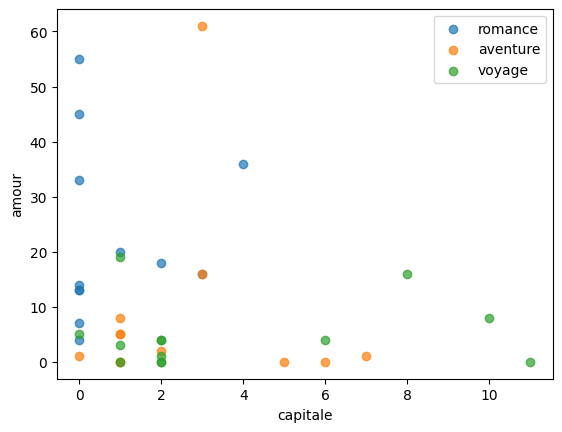

In [66]:
fig, ax = plt.subplots()

for genre in ('romance', 'aventure', 'voyage'):
    ax.scatter(voyage_compte[genres == genre],
               amour_compte[genres == genre],
               label=genre, alpha=0.7)

ax.set(xlabel='capitale', ylabel='amour')
plt.legend();



#### Sous-genre et Vecteurs

Comment pourrait-on vérifier ces impressions ?

In [67]:
romance_means = document_term_matrix[genres == 'romance'].mean(axis=0)
aventures_means = document_term_matrix[genres == 'aventure'].mean(axis=0)
voyage_means = document_term_matrix[genres == 'voyage'].mean(axis=0)

Les vecteurs moyens résultants contiendront une liste ou un vecteur unidimensionnel pour chaque terme de notre vocabulaire :

In [68]:
print(aventures_means.shape)

(42236,)


We still can use the precomputed indices to retrieve the mean frequency of individual words from these summary vectors:

In [69]:
print('Mean absolute frequency of "capitale"')
print(f'   in romance: {romance_means[voyage_idx]:.2f}')
print(f'   in aventures: {aventures_means[voyage_idx]:.2f}')
print(f'   in voyage: {voyage_means[voyage_idx]:.2f}')

Mean absolute frequency of "capitale"
   in romance: 0.83
   in aventures: 2.58
   in voyage: 3.69


The mean frequencies for these words are again revealing telling differences across our
three genres. This also becomes evident by plotting the mean values in a scatter plot:

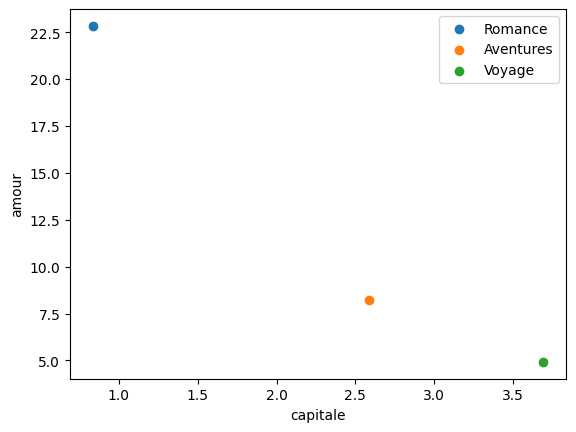

In [70]:
fig, ax = plt.subplots()

ax.scatter(
    romance_means[voyage_idx], romance_means[amour_idx], label='Romance')
ax.scatter(
    aventures_means[voyage_idx], aventures_means[amour_idx], label='Aventures')
ax.scatter(
    voyage_means[voyage_idx], voyage_means[amour_idx], label='Voyage')

ax.set(xlabel='capitale', ylabel='amour')
plt.legend();

### Calcul des distances entre les documents

Pauseons-nous un instant et examinons de plus près la représentation simplifiée de notre corpus sous la forme des trois centroïdes. Le chapitre a entrepris d'explorer comment nous pourrions appliquer un raisonnement spatial aux textes en utilisant un modèle sac-de-mots. Dans l'espace défini par ce modèle, nous devrions maintenant comprendre pourquoi les documents avec des représentations vectorielles similaires sont plus proches les uns des autres. Le pari pour le reste de ce chapitre sera que la <span class="index">distance géométrique</span> entre les vecteurs peut en effet servir de substitut aux jugements humains sur la dissimilarité de deux documents. Pour mettre cela en pratique, une définition précise de la distance dans un espace vectoriel doit être choisie. Examinons et illustrons un certain nombre de méthodes établies pour calculer la distance entre les vecteurs de documents et illustrons-les sur la base de nos trois vecteurs de genre. Pour simplifier, nous définissons trois vecteurs, un pour chaque genre. Nous utiliserons les points dans cet espace vectoriel "miniature" pour introduire plusieurs métriques de distance établies.

In [71]:
romance = np.array([romance_means[voyage_idx], romance_means[amour_idx]])
aventure = np.array([aventures_means[voyage_idx], aventures_means[amour_idx]])
voyage = np.array([voyage_means[voyage_idx], voyage_means[amour_idx]])

(sec-vector-space-model-euclidean-distance)=
#### Euclidean distance

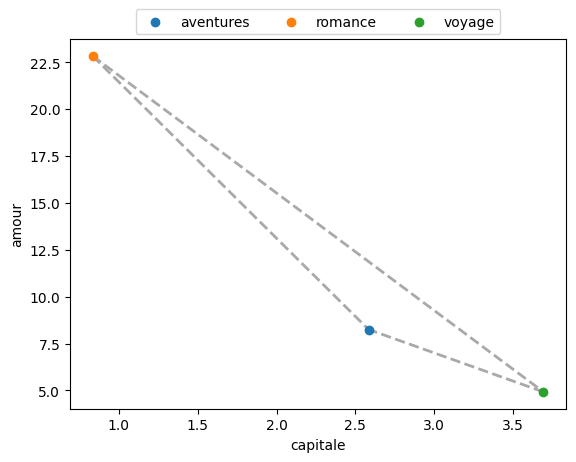

In [72]:
fig, ax = plt.subplots()

ax.plot([romance_means[voyage_idx], voyage_means[voyage_idx]],
        [romance_means[amour_idx], voyage_means[amour_idx]],
        'darkgrey', lw=2, ls='--')
ax.plot([romance_means[voyage_idx], aventures_means[voyage_idx]],
        [romance_means[amour_idx], aventures_means[amour_idx]],
        'darkgrey', lw=2, ls='--')
ax.plot([voyage_means[voyage_idx], aventures_means[voyage_idx]],
        [voyage_means[amour_idx], aventures_means[amour_idx]],
        'darkgrey', lw=2, ls='--')

ax.scatter(aventures_means[voyage_idx], aventures_means[amour_idx],
           label='aventures', zorder=3)
ax.scatter(romance_means[voyage_idx], romance_means[amour_idx],
           label='romance', zorder=3)
ax.scatter(voyage_means[voyage_idx], voyage_means[amour_idx],
           label='voyage', zorder=3)

ax.set(xlabel='capitale', ylabel='amour')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3);

Illustration de la métrique de distance euclidienne pour les vecteurs de genre.

Commençons peut-être par la distance la plus directe imaginable entre deux points dans l'espace, à savoir celle du "vol d'oiseau". La <span class="index">distance euclidienne</span> mesure intuitivement la longueur de la ligne droite qui relie deux points. Ces lignes droites sont indiquées en gris dans la Figure {numref}`fig-vector-space-model-euclidean`. Le calcul exact de la longueur de ces lignes se fait grâce à l'application de la distance euclidienne. En utilisant la notation mathématique, nous représentons un vecteur comme $\vec{x}$. Ainsi, étant donné deux vecteurs $\vec{a}$ et $\vec{b}$ avec $n$ coordonnées, la longueur de la ligne reliant deux points est calculée comme suit :

\begin{equation}
d_2(\vec{a}, \vec{b}) = \sqrt{\sum^n_{i=1} (a_i - b_i)^2}
\end{equation}


Tout le monde n'est pas familier avec ces notations mathématiques, expliquons donc brièvement comment lire la formule. Tout d'abord, $d_2$ est une fonction qui prend deux vecteurs, $\vec{a}$ et $\vec{b}$. Ensuite, $\sum^n_{i=1}$ est une notation de sommation ou de sigma, qui est une notation pratique pour exprimer la somme des valeurs d'une variable. Ici, les valeurs sont les différences au carré entre la $i$-ème valeur du vecteur $\vec{a}$ et la $i$-ème valeur du vecteur $\vec{b}$, c'est-à-dire $(a_i - b_i)^2$. Nous calculons ces différences pour toutes les $n$ coordonnées (d'où le petit $n$ au-dessus du signe sigma ; l'expression $i=1$ en dessous exprime que nous commençons à partir du tout premier élément de la série). Enfin, nous prenons la racine carrée ($\sqrt{}$) de cette somme. Parfois, les détails des formules deviennent plus clairs sous la forme de code. La formule de la distance euclidienne est relativement facile à traduire en la fonction Python suivante (qui se résume essentiellement à une seule ligne, grâce à la concision de NumPy) :

In [73]:
def euclidean_distance(a, b):
    """Calcule la distance euclidienne entre deux vecteurs.

    Remarque : ``numpy.linalg.norm(a - b)`` effectue le
    même calcul en utilisant une méthode légèrement plus rapide.

    Arguments :
        a (numpy.ndarray) : un vecteur de flottants ou d'entiers.
        b (numpy.ndarray) : un vecteur de flottants ou d'entiers.

    Returns :
        float : La distance euclidienne entre les vecteurs a et b.

    Examples :
        >>> import numpy as np
        >>> a = np.array([1, 4, 2, 8])
        >>> b = np.array([2, 1, 4, 7])
        >>> round(distance_euclidienne(a, b), 2)
        3.87
    """
    return np.sqrt(np.sum((a - b) ** 2))

Dans le bloc de code ci-dessous, nous appliquons cette <span class="index">métrique de distance</span> aux trois combinaisons par paires de nos trois vecteurs :

In [74]:
tc = euclidean_distance(romance, aventure)
print(f'romance - aventure:       {tc:.2f}')

ttc = euclidean_distance(romance, voyage)
print(f'romance - voyage: {ttc:.2f}')

ctc = euclidean_distance(aventure, voyage)
print(f' aventure - voyage: {ctc:.2f}')

romance - aventure:       14.69
romance - voyage: 18.14
 aventure - voyage: 3.51


Les distances obtenues confirment clairement notre impression visuelle tirée du graphique : les romans d'aventures et de voyage se ressemblent, et tous deux sont assez éloignés du roman sentimental.

#### La distance Cosine

![cosine](./data/cosine.png)

Illustration de la métrique de distance cosinus pour les vecteurs de genre.

Une alternative intéressante à la distance euclidienne est la célèbre <span class="index">distance cosinus</span> de la géométrie, qui est peut-être la métrique la plus largement utilisée pour calculer les dissimilarités entre les vecteurs de documents. Lors du calcul de la distance entre deux documents dans un espace, la distance euclidienne regarde simplement les coordonnées exactes des deux documents : elle les relie avec une ligne droite, pour ainsi dire, et renvoie la longueur de cette ligne. La distance cosinus, cependant, adopte une perspective assez différente : elle n'est pas principalement intéressée par ces deux *points* en tant que tels, mais elle les interprétera comme des flèches ou des *vecteurs* qui trouvent leur décalage par rapport à l'origine de l'espace. Ces vecteurs sont représentés par des lignes pointillées en gris dans la figure ci-dessous.

Pour estimer la similarité entre deux documents, la métrique mesurera la taille de l'angle entre les deux vecteurs qui sont définis par eux. La similarité entre deux vecteurs est mesurée par le cosinus de l'angle entre les deux vecteurs, car le cosinus d'un angle augmente à mesure que l'angle diminue. Les vecteurs pointant dans la même direction (c'est-à-dire ayant un petit angle entre eux) seront, selon cette mesure, évalués comme proches l'un de l'autre, même si la magnitude des vecteurs est radicalement différente et que la longueur de la ligne les reliant est grande.

La formule mathématique pour calculer la distance cosinus entre deux vecteurs $\vec{a}$ et $\vec{b}$ est légèrement plus complexe :

\begin{equation}
d_{\cos}(\vec a, \vec b) = 1 - \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
\end{equation}

Décomposons un peu cette formule. Le numérateur dans la fraction à droite implique un <span class="index">*produit scalaire*</span>. Il s'agit de la somme de la multiplication de chaque élément de $\vec{a}$ par son élément correspondant de $\vec{b}$, c'est-à-dire :

\begin{equation}
\vec{a} \cdot \vec{b} = \sum^n_{i=1} a_i b_i = a_1 b_1 + a_2 b_2 + \ldots + a_n b_n
\end{equation}

Avec NumPy, le produit scalaire peut être calculé avec <span class="index">`numpy.dot()`</span> (voir ci-dessous). Dans le dénominateur de la fraction, nous voyons comment la <span class="index">norme du vecteur</span> (appelée également sa longueur ou sa magnitude) est calculée pour $\vec{a}$ et $\vec{b}$, c'est-à-dire $|\vec{a}|$ et $|\vec{b}|$, et ces nombres sont ensuite multipliés. La norme d'un vecteur peut être calculée à l'aide de la fonction suivante :

In [75]:
def vector_len(v):
    """Compute the length (or norm) of a vector."""
    return np.sqrt(np.sum(v ** 2))

Un aspect reste à expliquer : pourquoi soustraire la fraction de la formule de 1 ? En réalité, la fraction dans la formule correspond à la *similarité cosinus* (qui sera toujours comprise entre 0 et 1 pour des vecteurs positifs). Pour transformer ce nombre en distance, nous prenons son complément en le soustrayant de 1.

Avec ces informations, nous sommes maintenant prêts à implémenter une fonction qui calcule la distance cosinus entre des vecteurs :

In [76]:
def cosine_distance(a, b):
    """Calcule la distance cosinus entre deux vecteurs.

    Arguments:
        a (numpy.ndarray): un vecteur de nombres flottants ou entiers.
        b (numpy.ndarray): un autre vecteur de nombres flottants ou entiers.

    Returns:
        float: distance cosinus entre les vecteurs a et b.

    Note:
        Voir aussi scipy.spatial.distance.cdist

    Examples:
        >>> import numpy as np
        >>> a = np.array([1, 4, 2, 8])
        >>> b = np.array([2, 1, 4, 7])
        >>> round(cosine_distance(a, b), 2)
        0.09

    """
    return 1 - np.dot(a, b) / (vector_len(a) * vector_len(b))

On peut encore une fois mesurer la distance entre les vecteurs

In [77]:
tc = cosine_distance(romance, aventure)
print(f'romance - aventure:       {tc:.2f}')

ttc = cosine_distance(romance, voyage)
print(f'romance - voyage: {ttc:.2f}')

ctc = cosine_distance(aventure, voyage)
print(f' aventure - voyage: {ctc:.2f}')

romance - aventure:       0.04
romance - voyage: 0.18
 aventure - voyage: 0.06


## Autres Modèles vectoriels - en TAL -> tf-idf, embeddings (DBOW)..
le tal c'est aussi du NER, du sentiment analysis, ...